In [48]:
import time
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


## Fonction pour initialiser une session Spark avec un nombre défini de CPU

In [49]:
def init_spark(num_cores):
    spark = SparkSession.builder \
        .appName("HiggsBosonClassification") \
        .config("spark.executor.memory", "6g") \
        .config("spark.driver.memory", "6g") \
        .config("spark.sql.shuffle.partitions", str(num_cores * 2)) \
        .config("spark.default.parallelism", str(num_cores * 2)) \
        .config("spark.executor.instances", "1") \
        .config("spark.executor.cores", num_cores) \
        .config("spark.driver.cores", num_cores) \
        .getOrCreate()
    return spark


## Fonction pour charger les données

In [50]:
def load_data(spark, train_path, test_path):
    train_df = spark.read.csv(train_path, header=False, inferSchema=True)
    test_df = spark.read.csv(test_path, header=False, inferSchema=True)
    return train_df, test_df


## Fonction pour renommer les colonnes et sélectionner les 21 premières caractéristiques

In [51]:
def preprocess_data(train_df, test_df):
    col_names = ["label"] + [f"feature_{i}" for i in range(1, 29)]
    train_df = train_df.toDF(*col_names)
    test_df = test_df.toDF(*col_names)

    # Sélectionner uniquement les 21 premières caractéristiques
    selected_features = [f"feature_{i}" for i in range(1, 22)]
    assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

    train_df = assembler.transform(train_df).select("features", "label")
    test_df = assembler.transform(test_df).select("features", "label")
    
    return train_df, test_df

## Fonction pour séparer les données en train/validation

In [52]:
def split_data(train_df):
    train_data, val_data = train_df.randomSplit([0.8, 0.2], seed=42)
    return train_data, val_data

## Fonction pour entraîner un modèle et mesurer son temps d'entraînement

In [53]:
def train_model(model, train_data):
    start_time = time.time()
    trained_model = model.fit(train_data)
    end_time = time.time()
    training_time = round(end_time - start_time, 2)
    return trained_model, training_time

## Fonction pour évaluer un modèle avec AUC et Accuracy

In [54]:
def evaluate_model(model, val_data):
    evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

    predictions = model.transform(val_data)
    auc = round(evaluator_auc.evaluate(predictions), 4)
    accuracy = round(evaluator_accuracy.evaluate(predictions), 4)
    
    return auc, accuracy

## Fonction principale pour exécuter l'entraînement et tester avec différents CPU


In [55]:
def run_experiment(train_path, test_path, cpu_tests):
    results = []

    for num_cores in cpu_tests:
        print(f"\n🔹 Test avec {num_cores} CPU cores...")

        # Initialisation de Spark
        spark = init_spark(num_cores)

        # Chargement des données
        train_df, test_df = load_data(spark, train_path, test_path)

        # Prétraitement
        train_df, test_df = preprocess_data(train_df, test_df)

        # Séparation en train/validation
        train_data, val_data = split_data(train_df)

        # Définition des modèles
        models = {
            "RandomForest": RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50),
            "LogisticRegression": LogisticRegression(labelCol="label", featuresCol="features", maxIter=20),
            "GBT": GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)
        }

        # Entraîner et évaluer chaque modèle
        model_results = {}
        for model_name, model in models.items():
            trained_model, training_time = train_model(model, train_data)
            auc, accuracy = evaluate_model(trained_model, val_data)

            model_results[model_name] = {
                "AUC": auc,
                "Accuracy": accuracy,
                "Training Time (s)": training_time,
            }

        # Ajouter les résultats pour ce test CPU
        results.append({"CPU Cores": num_cores, "Models": model_results})

        # Arrêter Spark pour libérer la mémoire
        spark.stop()

    return results

## Fonction pour afficher les résultats sous forme de DataFrame


🔹 Test avec 1 CPU cores...


25/03/10 14:59:11 WARN MemoryStore: Not enough space to cache rdd_48_4 in memory! (computed 20.4 MiB so far)
25/03/10 14:59:11 WARN BlockManager: Persisting block rdd_48_4 to disk instead.
25/03/10 14:59:11 WARN MemoryStore: Not enough space to cache rdd_48_2 in memory! (computed 20.4 MiB so far)
25/03/10 14:59:11 WARN BlockManager: Persisting block rdd_48_2 to disk instead.
25/03/10 14:59:11 WARN MemoryStore: Not enough space to cache rdd_48_1 in memory! (computed 20.4 MiB so far)
25/03/10 14:59:11 WARN BlockManager: Persisting block rdd_48_1 to disk instead.



🔹 Test avec 2 CPU cores...


25/03/10 15:00:43 WARN MemoryStore: Not enough space to cache rdd_48_3 in memory! (computed 20.4 MiB so far)
25/03/10 15:00:43 WARN BlockManager: Persisting block rdd_48_3 to disk instead.
25/03/10 15:00:43 WARN MemoryStore: Not enough space to cache rdd_48_4 in memory! (computed 20.4 MiB so far)
25/03/10 15:00:43 WARN BlockManager: Persisting block rdd_48_4 to disk instead.
25/03/10 15:00:43 WARN MemoryStore: Not enough space to cache rdd_48_1 in memory! (computed 45.9 MiB so far)
25/03/10 15:00:43 WARN BlockManager: Persisting block rdd_48_1 to disk instead.
25/03/10 15:00:43 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 45.9 MiB so far)
25/03/10 15:00:43 WARN BlockManager: Persisting block rdd_48_0 to disk instead.
25/03/10 15:00:43 WARN MemoryStore: Not enough space to cache rdd_48_2 in memory! (computed 45.9 MiB so far)
25/03/10 15:00:43 WARN BlockManager: Persisting block rdd_48_2 to disk instead.



🔹 Test avec 4 CPU cores...


25/03/10 15:02:19 WARN MemoryStore: Not enough space to cache rdd_48_6 in memory! (computed 13.4 MiB so far)
25/03/10 15:02:19 WARN BlockManager: Persisting block rdd_48_6 to disk instead.
25/03/10 15:02:19 WARN MemoryStore: Not enough space to cache rdd_48_5 in memory! (computed 13.4 MiB so far)
25/03/10 15:02:19 WARN BlockManager: Persisting block rdd_48_5 to disk instead.
25/03/10 15:02:19 WARN MemoryStore: Not enough space to cache rdd_48_7 in memory! (computed 20.4 MiB so far)
25/03/10 15:02:19 WARN BlockManager: Persisting block rdd_48_7 to disk instead.
25/03/10 15:02:19 WARN MemoryStore: Not enough space to cache rdd_48_1 in memory! (computed 20.4 MiB so far)
25/03/10 15:02:19 WARN BlockManager: Persisting block rdd_48_1 to disk instead.
25/03/10 15:02:19 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 20.4 MiB so far)
25/03/10 15:02:19 WARN BlockManager: Persisting block rdd_48_0 to disk instead.
25/03/10 15:02:19 WARN MemoryStore: Not enough space to


📊 Résultats Comparatifs :
 CPU Cores              Model    AUC  Accuracy  Training Time (s)
         1       RandomForest 0.6369    0.5881              27.40
         1 LogisticRegression 0.5939    0.5651               6.62
         1                GBT 0.6932    0.6394              36.01
         2       RandomForest 0.6369    0.5881              23.37
         2 LogisticRegression 0.5939    0.5651               7.35
         2                GBT 0.6932    0.6394              38.46
         4       RandomForest 0.6359    0.5894              22.08
         4 LogisticRegression 0.5933    0.5656               6.99
         4                GBT 0.6943    0.6407              37.92


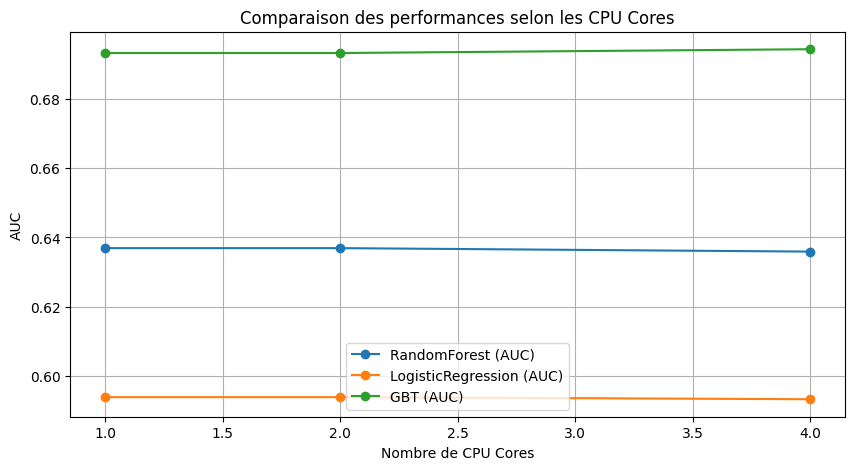

In [56]:
import pandas as pd

def display_results(results):
    df_results = []

    for res in results:
        num_cores = res["CPU Cores"]
        for model, metrics in res["Models"].items():
            df_results.append({
                "CPU Cores": num_cores,
                "Model": model,
                "AUC": metrics["AUC"],
                "Accuracy": metrics["Accuracy"],
                "Training Time (s)": metrics["Training Time (s)"]
            })

    df_results = pd.DataFrame(df_results)

    # 🔹 Afficher le tableau dans la console
    print("\n📊 Résultats Comparatifs :")
    print(df_results.to_string(index=False))

    # 🔹 Générer un graphique avec Matplotlib
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for model in df_results["Model"].unique():
        subset = df_results[df_results["Model"] == model]
        plt.plot(subset["CPU Cores"], subset["AUC"], marker="o", linestyle="-", label=f"{model} (AUC)")

    plt.xlabel("Nombre de CPU Cores")
    plt.ylabel("AUC")
    plt.title("Comparaison des performances selon les CPU Cores")
    plt.legend()
    plt.grid()
    plt.show()

# 🚀 Exécution du script
if __name__ == "__main__":
    train_path = "HIGGS-Train.csv"
    test_path = "HIGGS-Test.csv"
    cpu_tests = [1, 2, 4]  # Modifier selon les ressources disponibles

    results = run_experiment(train_path, test_path, cpu_tests)
    display_results(results)


## Exécution du script